In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Importing Dataset from Google Drive
dataset_path = 'datasets/finalProjectDataset.csv'
data = pd.read_csv(dataset_path)

print(data.head())

   RecordID         AQI        PM10       PM2_5         NO2        SO2  \
0         1  187.270059  295.853039   13.038560    6.639263  66.161150   
1         2  475.357153  246.254703    9.984497   16.318326  90.499523   
2         3  365.996971   84.443191   23.111340   96.317811  17.875850   
3         4  299.329242   21.020609   14.273403   81.234403  48.323616   
4         5   78.009320   16.987667  152.111623  121.235461  90.866167   

           O3  Temperature   Humidity  WindSpeed  RespiratoryCases  \
0   54.624280     5.150335  84.424344   6.137755                 7   
1  169.621728     1.543378  46.851415   4.521422                10   
2    9.006794     1.169483  17.806977  11.157384                13   
3   93.161033    21.925276  99.473373  15.302500                 8   
4  241.795138     9.217517  24.906837  14.534733                 9   

   CardiovascularCases  HospitalAdmissions  HealthImpactScore  \
0                    5                   1          97.244041   
1   

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Feature engineering: add interaction terms
data['PM2_5_PM10_ratio'] = data['PM2_5'] / data['PM10']
data['temp_humidity_interaction'] = data['Temperature'] * data['Humidity']

# Normalize features
feature_columns = [
    'AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity',
    'WindSpeed', 'RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions'
]
feature_columns2 = [
    'AQI', 'NO2', 'SO2', 'O3',
    'WindSpeed', 'RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions',
    'PM2_5_PM10_ratio', 'temp_humidity_interaction'
]
data[feature_columns] = (data[feature_columns] - data[feature_columns].min()) / (
    data[feature_columns].max() - data[feature_columns].min()
)

# Convert target to one-hot encoding
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y.astype(int)]

# Dataset preparation
X = data[feature_columns].values
y = data['HealthImpactClass'].values
num_classes = len(data['HealthImpactClass'].value_counts())
y_one_hot = one_hot_encode(y, num_classes)
print(f'num_classes: {num_classes}')
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Neural network parameters
input_size = X_train.shape[1]  # Number of features
hidden_layer_1 = 16
hidden_layer_2 = 8
output_size = num_classes
learning_rate = 0.01
epochs = 500

# Initialize weights and biases
np.random.seed(42)
weights = {
    # "W1": np.random.randn(input_size, hidden_layer_1) * 0.01,
    "W1": np.ones((input_size, hidden_layer_1)),
    "b1": np.zeros((1, hidden_layer_1)),
    # "W2": np.random.randn(hidden_layer_1, hidden_layer_2) * 0.01,
    "W2": np.ones((hidden_layer_1, hidden_layer_2)),
    "b2": np.zeros((1, hidden_layer_2)),
    # "W3": np.random.randn(hidden_layer_2, output_size) * 0.01,
    "W3": np.ones((hidden_layer_2, output_size)),
    "b3": np.zeros((1, output_size)),
}

# Activation functions
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

# Loss function: Categorical cross-entropy
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

# Forward pass
def forward_pass(X, weights):
    Z1 = np.dot(X, weights["W1"]) + weights["b1"]
    A1 = relu(Z1)
    Z2 = np.dot(A1, weights["W2"]) + weights["b2"]
    A2 = relu(Z2)
    Z3 = np.dot(A2, weights["W3"]) + weights["b3"]
    A3 = softmax(Z3)
    activations = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    return A3, activations

# Backward pass
def backward_pass(X, y_true, activations, weights):
    m = X.shape[0]
    A1, A2, A3 = activations["A1"], activations["A2"], activations["A3"]
    Z1, Z2 = activations["Z1"], activations["Z2"]

    # Gradient for output layer
    dZ3 = A3 - y_true
    dW3 = np.dot(A2.T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    # Gradient for second hidden layer
    dA2 = np.dot(dZ3, weights["W3"].T)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Gradient for first hidden layer
    dA1 = np.dot(dZ2, weights["W2"].T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Gradients
    gradients = {"dW3": dW3, "db3": db3, "dW2": dW2, "db2": db2, "dW1": dW1, "db1": db1}
    return gradients

# Update weights
def update_weights(weights, gradients, learning_rate):
    weights["W1"] -= learning_rate * gradients["dW1"]
    weights["b1"] -= learning_rate * gradients["db1"]
    weights["W2"] -= learning_rate * gradients["dW2"]
    weights["b2"] -= learning_rate * gradients["db2"]
    weights["W3"] -= learning_rate * gradients["dW3"]
    weights["b3"] -= learning_rate * gradients["db3"]
    return weights

# Training loop
losses = []
for epoch in range(epochs):
    # Forward pass
    A3, activations = forward_pass(X_train, weights)
    
    # Compute loss
    loss = cross_entropy_loss(y_train, A3)
    losses.append(loss)
    
    # Backward pass
    gradients = backward_pass(X_train, y_train, activations, weights)
    
    # Update weights
    weights = update_weights(weights, gradients, learning_rate)
    
    # Print progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

# Evaluate on the test set
A3_test, _ = forward_pass(X_test, weights)
y_pred = np.argmax(A3_test, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {accuracy:.4f}")

num_classes: 5
Epoch 0/500, Loss: 1.6094
Epoch 50/500, Loss: 3.1428
Epoch 100/500, Loss: 2.6599
Epoch 150/500, Loss: 7.1903
Epoch 200/500, Loss: 3.1410
Epoch 250/500, Loss: 2.6252
Epoch 300/500, Loss: 1.6338
Epoch 350/500, Loss: 2.9191
Epoch 400/500, Loss: 0.6182
Epoch 450/500, Loss: 1.6363
Test Accuracy: 0.8194


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

dataset_path = 'datasets/finalProjectDataset.csv'
data = pd.read_csv(dataset_path)

# Feature engineering: add interaction terms
data['PM2_5_PM10_ratio'] = data['PM2_5'] / data['PM10']
data['temp_humidity_interaction'] = data['Temperature'] * data['Humidity']

# Normalize features
feature_columns = [
    'AQI', 'NO2', 'SO2', 'O3',
    'WindSpeed', 'RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions',
    'PM2_5_PM10_ratio', 'temp_humidity_interaction'
]
data[feature_columns] = (data[feature_columns] - data[feature_columns].min()) / (
    data[feature_columns].max() - data[feature_columns].min()
)

# Convert target to one-hot encoding
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y.astype(int)]

# Dataset preparation
X = data[feature_columns].values
y = data['HealthImpactClass'].values
num_classes = len(data['HealthImpactClass'].value_counts())
y_one_hot = one_hot_encode(y, num_classes)

X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Neural network parameters
input_size = X_train.shape[1]  # Number of features
hidden_layer_1 = 4
hidden_layer_2 = 2
output_size = num_classes
learning_rate = 0.1
epochs = 100

# Initialize weights and biases
np.random.seed(42)
weights = {
    "W1": np.random.randn(input_size, hidden_layer_1)* np.sqrt(2 / input_size),
    "b1": np.zeros((1, hidden_layer_1)),
    "W2": np.random.randn(hidden_layer_1, hidden_layer_2) * np.sqrt(2 / input_size),
    "b2": np.zeros((1, hidden_layer_2)),
    "W3": np.random.randn(hidden_layer_2, output_size) ,
    "b3": np.zeros((1, output_size)),
}

gamma1 = np.ones((1, hidden_layer_1))
beta1 = np.zeros((1, hidden_layer_1))
# for key in weights:
#     if "W" in key:
#         print(f"{key} mean: {np.mean(weights[key]):.5f}, std: {np.std(weights[key]):.5f}")

# Activation functions
def leaky_relu(Z, alpha=0.01):
    return np.maximum(alpha * Z, Z)

def leaky_relu_derivative(Z, alpha=0.01):
    return np.where(Z > 0, 1, alpha)

def softmax(Z, scale=100):
    Z_scaled = Z * scale
    exp_Z = np.exp(Z_scaled - np.max(Z_scaled, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

def clip_gradients(gradients, clip_value=1.0):
    for key in gradients:
        gradients[key] = np.clip(gradients[key], -clip_value, clip_value)
    return gradients
# Batch norm implementation
def batch_norm(Z, gamma, beta, epsilon=1e-5):
    mean = np.mean(Z, axis=0)
    variance = np.var(Z, axis=0)
    Z_normalized = (Z - mean) / np.sqrt(variance + epsilon)
    return gamma * Z_normalized + beta
    
# Loss function: Categorical cross-entropy
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

# Forward pass
def forward_pass(X, weights):
    Z1 = np.dot(X, weights["W1"]) + weights["b1"]
    Z1 = batch_norm(Z1, gamma1, beta1)
    A1 = leaky_relu(Z1)
    Z2 = np.dot(A1, weights["W2"]) + weights["b2"]
    Z1 = batch_norm(Z1, gamma1, beta1)
    A2 = leaky_relu(Z2)
    Z3 = np.dot(A2, weights["W3"]) + weights["b3"]
    A3 = softmax(Z3, 10)
    activations = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    return A3, activations

# Backward pass
def backward_pass(X, y_true, activations, weights):
    m = X.shape[0]
    A1, A2, A3 = activations["A1"], activations["A2"], activations["A3"]
    Z1, Z2 = activations["Z1"], activations["Z2"]

    # Gradient for output layer
    dZ3 = A3 - y_true
    dW3 = np.dot(A2.T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    # Gradient for second hidden layer
    dA2 = np.dot(dZ3, weights["W3"].T)
    dZ2 = dA2 * leaky_relu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Gradient for first hidden layer
    dA1 = np.dot(dZ2, weights["W2"].T)
    dZ1 = dA1 * leaky_relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Gradients
    gradients = {"dW3": dW3, "db3": db3, "dW2": dW2, "db2": db2, "dW1": dW1, "db1": db1}
    gradients = clip_gradients(gradients, clip_value=1.0)

    # # Check activations
    # print("A1 mean:", np.mean(activations["A1"]), "A1 std:", np.std(activations["A1"]))
    # print("A2 mean:", np.mean(activations["A2"]), "A2 std:", np.std(activations["A2"]))
    # print("A3 mean:", np.mean(A3), "A3 std:", np.std(A3))

    # Check gradients
    for key, grad in gradients.items():
        print(f"{key} mean: {np.mean(grad):.5f}, std: {np.std(grad):.5f}")
    return gradients

# Update weights
def update_weights(weights, gradients, learning_rate):
    weights["W1"] -= learning_rate * gradients["dW1"]
    weights["b1"] -= learning_rate * gradients["db1"]
    weights["W2"] -= learning_rate * gradients["dW2"]
    weights["b2"] -= learning_rate * gradients["db2"]
    weights["W3"] -= learning_rate * gradients["dW3"]
    weights["b3"] -= learning_rate * gradients["db3"]
    return weights

# Training loop
# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement
best_loss = np.inf
wait = 0

# Training loop with early stopping
losses = []
val_losses = []  # Track validation losses
for epoch in range(epochs):
    # Forward pass for training
    A3, activations = forward_pass(X_train_split, weights)
    loss = cross_entropy_loss(y_train_split, A3)
    losses.append(loss)

    # Backward pass and update weights
    gradients = backward_pass(X_train_split, y_train_split, activations, weights)
    weights = update_weights(weights, gradients, learning_rate)

    # Forward pass for validation
    A3_val, _ = forward_pass(X_val, weights)
    val_loss = cross_entropy_loss(y_val, A3_val)
    val_losses.append(val_loss)

    # Check early stopping criteria
    if val_loss < best_loss:
        best_loss = val_loss
        wait = 0  # Reset patience counter
        best_weights = weights.copy()  # Save best weights
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

    # Print progress
    if epoch % 50 == 0 or wait == 0:  # Report progress every 50 epochs or after improvement
        print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")

# Load best weights
weights = best_weights

# Evaluate on the test set
A3_test, _ = forward_pass(X_test, weights)
y_pred = np.argmax(A3_test, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {accuracy:.4f}")

# print()
# print(weights)
# print()
# print("y_pred")
# for i in y_pred:
#     print(i)
# print()
# print("y_true")
# for i in y_true:
#     print(i)

dW3 mean: 0.00000, std: 0.09031
db3 mean: 0.00000, std: 0.42167
dW2 mean: 0.32142, std: 0.16636
db2 mean: 0.72129, std: 0.23270
dW1 mean: 0.04693, std: 0.08883
db1 mean: 0.10256, std: 0.18624
Epoch 0/100, Loss: 5.4022, Val Loss: 2.9067
dW3 mean: -0.00000, std: 0.04681
db3 mean: -0.00000, std: 0.30559
dW2 mean: 0.21201, std: 0.13131
db2 mean: 0.41867, std: 0.04634
dW1 mean: 0.02497, std: 0.05782
db1 mean: 0.05465, std: 0.12172
Epoch 1/100, Loss: 2.9849, Val Loss: 1.8256
dW3 mean: -0.00000, std: 0.02847
db3 mean: -0.00000, std: 0.21121
dW2 mean: 0.14779, std: 0.11127
db2 mean: 0.27378, std: 0.00033
dW1 mean: 0.01428, std: 0.03669
db1 mean: 0.03124, std: 0.07738
Epoch 2/100, Loss: 1.8681, Val Loss: 1.2923
dW3 mean: -0.00000, std: 0.01821
db3 mean: 0.00000, std: 0.14164
dW2 mean: 0.10551, std: 0.08959
db2 mean: 0.18633, std: 0.01030
dW1 mean: 0.00874, std: 0.02311
db1 mean: 0.01911, std: 0.04871
Epoch 3/100, Loss: 1.3117, Val Loss: 1.0242
dW3 mean: 0.00000, std: 0.01209
db3 mean: 0.00000, 

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
dataset_path = 'datasets/finalProjectDataset.csv'
data = pd.read_csv(dataset_path)
# Feature engineering: add interaction terms
data['PM2_5_PM10_ratio'] = data['PM2_5'] / data['PM10']
data['temp_humidity_interaction'] = data['Temperature'] * data['Humidity']

# Normalize features
feature_columns = [
    'AQI', 'NO2', 'SO2', 'O3',
    'WindSpeed', 'RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions',
    'PM2_5_PM10_ratio', 'temp_humidity_interaction'
]
data[feature_columns] = (data[feature_columns] - data[feature_columns].min()) / (
    data[feature_columns].max() - data[feature_columns].min()
)

# Convert target to one-hot encoding
def one_hot_encode(y, num_classes=5):  # Fixed to 5 classes
    return np.eye(num_classes)[y.astype(int)]

# Dataset preparation
X = data[feature_columns].values
y = data['HealthImpactClass'].values
y_one_hot = one_hot_encode(y)  # Always 5 classes

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Neural network parameters
input_size = X_train.shape[1]
hidden_layer_1 = 32  # Increased for better capacity
hidden_layer_2 = 16
output_size = 5  # Fixed to 5 classes
learning_rate = 0.001  # Reduced for better stability
epochs = 500

# Initialize weights with He initialization
np.random.seed(42)
weights = {
    # He initialization: sqrt(2/n_inputs)
    "W1": np.random.randn(input_size, hidden_layer_1) * np.sqrt(2/input_size),
    "b1": np.zeros((1, hidden_layer_1)),
    "W2": np.random.randn(hidden_layer_1, hidden_layer_2) * np.sqrt(2/hidden_layer_1),
    "b2": np.zeros((1, hidden_layer_2)),
    "W3": np.random.randn(hidden_layer_2, output_size) * np.sqrt(2/hidden_layer_2),
    "b3": np.zeros((1, output_size)),
}

# Activation functions
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

# Loss function: Categorical cross-entropy
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

# Forward pass
def forward_pass(X, weights):
    Z1 = np.dot(X, weights["W1"]) + weights["b1"]
    A1 = relu(Z1)
    Z2 = np.dot(A1, weights["W2"]) + weights["b2"]
    A2 = relu(Z2)
    Z3 = np.dot(A2, weights["W3"]) + weights["b3"]
    A3 = softmax(Z3)
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    return A3, cache

# Backward pass
def backward_pass(X, y_true, cache, weights):
    m = X.shape[0]
    A1, A2, A3 = cache["A1"], cache["A2"], cache["A3"]
    Z1, Z2 = cache["Z1"], cache["Z2"]

    dZ3 = A3 - y_true
    dW3 = np.dot(A2.T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    dA2 = np.dot(dZ3, weights["W3"].T)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = np.dot(dZ2, weights["W2"].T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    gradients = {"dW3": dW3, "db3": db3, "dW2": dW2, "db2": db2, "dW1": dW1, "db1": db1}
    return gradients

# Update weights
def update_weights(weights, gradients, learning_rate):
    weights["W1"] -= learning_rate * gradients["dW1"]
    weights["b1"] -= learning_rate * gradients["db1"]
    weights["W2"] -= learning_rate * gradients["dW2"]
    weights["b2"] -= learning_rate * gradients["db2"]
    weights["W3"] -= learning_rate * gradients["dW3"]
    weights["b3"] -= learning_rate * gradients["db3"]
    return weights

# Training loop with early stopping
best_loss = float('inf')
patience = 10
patience_counter = 0
losses = []

for epoch in range(epochs):
    # Forward pass
    A3, cache = forward_pass(X_train, weights)
    
    # Compute loss
    loss = cross_entropy_loss(y_train, A3)
    losses.append(loss)
    
    # Early stopping check
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0
        best_weights = weights.copy()
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
    
    # Backward pass
    gradients = backward_pass(X_train, y_train, cache, weights)
    
    # Update weights
    weights = update_weights(weights, gradients, learning_rate)
    
    # Print progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

# Use best weights for evaluation
weights = best_weights

# Evaluate on the test set
A3_test, _ = forward_pass(X_test, weights)
y_pred = np.argmax(A3_test, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate and print metrics
accuracy = np.mean(y_pred == y_true)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

Epoch 0/500, Loss: 2.5550
Epoch 50/500, Loss: 2.0196
Epoch 100/500, Loss: 1.5773
Epoch 150/500, Loss: 1.2670
Epoch 200/500, Loss: 1.0609
Epoch 250/500, Loss: 0.9263
Epoch 300/500, Loss: 0.8388
Epoch 350/500, Loss: 0.7818
Epoch 400/500, Loss: 0.7441
Epoch 450/500, Loss: 0.7188

Test Accuracy: 0.8194

Confusion Matrix:
[[953   0   0   0   0]
 [124   0   0   0   0]
 [ 53   0   0   0   0]
 [ 20   0   0   0   0]
 [ 13   0   0   0   0]]


In [6]:
print("y_pred")
# for i in y_true:
#     print(i)

y_pred


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('datasets/finalProjectDataset.csv')

# Feature engineering: add interaction terms
data['PM2_5_PM10_ratio'] = data['PM2_5'] / data['PM10']
data['temp_humidity_interaction'] = data['Temperature'] * data['Humidity']

# Normalize features
feature_columns = [
    'AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity',
    'WindSpeed', 'RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions',
    'PM2_5_PM10_ratio', 'temp_humidity_interaction'
]
data[feature_columns] = (data[feature_columns] - data[feature_columns].min()) / (
    data[feature_columns].max() - data[feature_columns].min()
)

# Convert target to one-hot encoding
def one_hot_encode(y, num_classes=5):
    return np.eye(num_classes)[y.astype(int)]

# Dataset preparation
X = data[feature_columns].values
y = data['HealthImpactClass'].values

# Calculate class weights
unique, counts = np.unique(y, return_counts=True)
total_samples = len(y)
class_weights = {cls: total_samples / (len(unique) * count) for cls, count in zip(unique, counts)}

y_one_hot = one_hot_encode(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Neural network parameters
input_size = X_train.shape[1]
hidden_layer_1 = 64  # Increased size
hidden_layer_2 = 32
output_size = 5
learning_rate = 0.005  # Adjusted learning rate
epochs = 1000

# Batch normalization
def batch_norm(X, gamma=1.0, beta=0.0, eps=1e-8):
    mu = np.mean(X, axis=0)
    var = np.var(X, axis=0) + eps
    X_norm = (X - mu) / np.sqrt(var)
    out = gamma * X_norm + beta
    cache = (X_norm, var, mu, gamma)
    return out, cache

def batch_norm_backward(dout, cache):
    X_norm, var, mu, gamma = cache
    N = dout.shape[0]
    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout * X_norm, axis=0)
    dX_norm = dout * gamma
    dvar = np.sum(dX_norm * (X_norm) * (-0.5) / var, axis=0)
    dmu = np.sum(dX_norm * (-1/np.sqrt(var)), axis=0)
    dX = dX_norm / np.sqrt(var) + 2 * dvar * (X_norm) / N + dmu / N
    return dX, dgamma, dbeta

# Initialize weights with He initialization
np.random.seed(42)
weights = {
    "W1": np.random.randn(input_size, hidden_layer_1) * np.sqrt(2/input_size),
    "b1": np.zeros((1, hidden_layer_1)),
    "gamma1": np.ones(hidden_layer_1),
    "beta1": np.zeros(hidden_layer_1),
    "W2": np.random.randn(hidden_layer_1, hidden_layer_2) * np.sqrt(2/hidden_layer_1),
    "b2": np.zeros((1, hidden_layer_2)),
    "gamma2": np.ones(hidden_layer_2),
    "beta2": np.zeros(hidden_layer_2),
    "W3": np.random.randn(hidden_layer_2, output_size) * np.sqrt(2/hidden_layer_2),
    "b3": np.zeros((1, output_size)),
}

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

def forward_pass(X, weights, training=True):
    Z1 = np.dot(X, weights["W1"]) + weights["b1"]
    BN1, cache_bn1 = batch_norm(Z1, weights["gamma1"], weights["beta1"]) if training else (Z1, None)
    A1 = relu(BN1)
    
    Z2 = np.dot(A1, weights["W2"]) + weights["b2"]
    BN2, cache_bn2 = batch_norm(Z2, weights["gamma2"], weights["beta2"]) if training else (Z2, None)
    A2 = relu(BN2)
    
    Z3 = np.dot(A2, weights["W3"]) + weights["b3"]
    A3 = softmax(Z3)
    
    cache = {
        "Z1": Z1, "BN1": BN1, "cache_bn1": cache_bn1, "A1": A1,
        "Z2": Z2, "BN2": BN2, "cache_bn2": cache_bn2, "A2": A2,
        "Z3": Z3, "A3": A3
    }
    return A3, cache

def weighted_cross_entropy_loss(y_true, y_pred, class_weights):
    m = y_true.shape[0]
    weights = np.sum(y_true * np.array([class_weights[i] for i in range(5)]), axis=1)
    return -np.sum(weights[:, np.newaxis] * y_true * np.log(y_pred + 1e-8)) / m

def backward_pass(X, y_true, cache, weights):
    m = X.shape[0]
    
    # Output layer
    dZ3 = cache["A3"] - y_true
    dW3 = np.dot(cache["A2"].T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m
    
    # Second hidden layer
    dA2 = np.dot(dZ3, weights["W3"].T)
    dBN2 = dA2 * relu_derivative(cache["BN2"])
    dZ2, dgamma2, dbeta2 = batch_norm_backward(dBN2, cache["cache_bn2"])
    dW2 = np.dot(cache["A1"].T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    # First hidden layer
    dA1 = np.dot(dZ2, weights["W2"].T)
    dBN1 = dA1 * relu_derivative(cache["BN1"])
    dZ1, dgamma1, dbeta1 = batch_norm_backward(dBN1, cache["cache_bn1"])
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    return {
        "dW1": dW1, "db1": db1, "dgamma1": dgamma1, "dbeta1": dbeta1,
        "dW2": dW2, "db2": db2, "dgamma2": dgamma2, "dbeta2": dbeta2,
        "dW3": dW3, "db3": db3
    }

def update_weights(weights, gradients, learning_rate):
    weights["W1"] -= learning_rate * gradients["dW1"]
    weights["b1"] -= learning_rate * gradients["db1"]
    weights["gamma1"] -= learning_rate * gradients["dgamma1"]
    weights["beta1"] -= learning_rate * gradients["dbeta1"]
    
    weights["W2"] -= learning_rate * gradients["dW2"]
    weights["b2"] -= learning_rate * gradients["db2"]
    weights["gamma2"] -= learning_rate * gradients["dgamma2"]
    weights["beta2"] -= learning_rate * gradients["dbeta2"]
    
    weights["W3"] -= learning_rate * gradients["dW3"]
    weights["b3"] -= learning_rate * gradients["db3"]
    return weights

# Training loop with monitoring
best_loss = float('inf')
patience = 15
patience_counter = 0
losses = []

for epoch in range(epochs):
    # Forward pass
    A3, cache = forward_pass(X_train, weights, training=True)
    
    # Compute weighted loss
    loss = weighted_cross_entropy_loss(y_train, A3, class_weights)
    losses.append(loss)
    
    # Early stopping check
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0
        best_weights = weights.copy()
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
    
    # Backward pass
    gradients = backward_pass(X_train, y_train, cache, weights)
    
    # Update weights
    weights = update_weights(weights, gradients, learning_rate)
    
    # Monitor predictions periodically
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")
        A3_train, _ = forward_pass(X_train[:5], weights, training=False)
        print("Sample predictions:", np.argmax(A3_train, axis=1))
        print("Sample true values:", np.argmax(y_train[:5], axis=1))

# Use best weights for evaluation
weights = best_weights

# Evaluate on the test set
A3_test, _ = forward_pass(X_test, weights, training=False)
y_pred = np.argmax(A3_test, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate and print metrics
accuracy = np.mean(y_pred == y_true)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Print confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Print sample predictions
print("\nSample Predictions vs True Values:")
for i in range(min(20, len(y_pred))):
    print(f"True: {y_true[i]}, Predicted: {y_pred[i]}")

Epoch 0/1000, Loss: 2.1621
Sample predictions: [2 2 2 2 2]
Sample true values: [0 0 0 0 0]
Early stopping at epoch 15

Test Accuracy: 0.0456

Confusion Matrix:
[[  0   0 953   0   0]
 [  0   0 124   0   0]
 [  0   0  53   0   0]
 [  0   0  20   0   0]
 [  0   0  13   0   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       953
           1       0.00      0.00      0.00       124
           2       0.05      1.00      0.09        53
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        13

    accuracy                           0.05      1163
   macro avg       0.01      0.20      0.02      1163
weighted avg       0.00      0.05      0.00      1163


Sample Predictions vs True Values:
True: 0, Predicted: 2
True: 0, Predicted: 2
True: 0, Predicted: 2
True: 0, Predicted: 2
True: 0, Predicted: 2
True: 1, Predicted: 2
True: 4, Predicted: 2
True: 0, Predicted: 2

/home/mohit-marfatia/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mohit-marfatia/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mohit-marfatia/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Feature engineering: add interaction terms
data['PM2_5_PM10_ratio'] = data['PM2_5'] / data['PM10']
data['temp_humidity_interaction'] = data['Temperature'] * data['Humidity']

# Normalize features
feature_columns = [
    'AQI', 'PM2_5_PM10_ratio', 'NO2', 'SO2', 'O3', 'temp_humidity_interaction',
    'WindSpeed', 'RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions'
]
data[feature_columns] = (data[feature_columns] - data[feature_columns].min()) / (
    data[feature_columns].max() - data[feature_columns].min()
)

# Convert target to one-hot encoding
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y.astype(int)]

# Dataset preparation
X = data[feature_columns].values
y = data['HealthImpactClass'].values
num_classes = len(data['HealthImpactClass'].value_counts())

# Ensure y is an integer array for class weight calculation
y = y.astype(int)

y_one_hot = one_hot_encode(y, num_classes)
print(f'num_classes: {num_classes}')
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Compute class weights based on the class distribution (use y, not y_one_hot)
class_counts = np.bincount(y)
print(f"Class Counts: {class_counts}")

class_weights = 1. / class_counts
class_weights = class_weights / np.sum(class_weights)  # Normalize the weights
print(f"Class Weights: {class_weights}")

# Neural network parameters
input_size = X_train.shape[1]  # Number of features
hidden_layer_1 = 64  # Increased neurons for more complexity
hidden_layer_2 = 32
output_size = num_classes
learning_rate = 0.001  # Learning rate
epochs = 500

# Initialize weights and biases
np.random.seed(42)
weights = {
    "W1": np.random.randn(input_size, hidden_layer_1) * 0.01,
    "b1": np.zeros((1, hidden_layer_1)),
    "W2": np.random.randn(hidden_layer_1, hidden_layer_2) * 0.01,
    "b2": np.zeros((1, hidden_layer_2)),
    "W3": np.random.randn(hidden_layer_2, output_size) * 0.01,
    "b3": np.zeros((1, output_size)),
}

# Activation functions
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

# Weighted Cross-Entropy Loss Function
def weighted_cross_entropy_loss(y_true, y_pred, class_weights):
    m = y_true.shape[0]
    loss = -np.sum(class_weights * y_true * np.log(y_pred + 1e-8)) / m
    return loss

# Forward pass
def forward_pass(X, weights):
    Z1 = np.dot(X, weights["W1"]) + weights["b1"]
    A1 = relu(Z1)
    Z2 = np.dot(A1, weights["W2"]) + weights["b2"]
    A2 = relu(Z2)
    Z3 = np.dot(A2, weights["W3"]) + weights["b3"]
    A3 = softmax(Z3)
    activations = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    return A3, activations

# Backward pass
def backward_pass(X, y_true, activations, weights, class_weights):
    m = X.shape[0]
    A1, A2, A3 = activations["A1"], activations["A2"], activations["A3"]
    Z1, Z2 = activations["Z1"], activations["Z2"]

    # Gradient for output layer
    dZ3 = A3 - y_true
    dW3 = np.dot(A2.T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    # Gradient for second hidden layer
    dA2 = np.dot(dZ3, weights["W3"].T)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Gradient for first hidden layer
    dA1 = np.dot(dZ2, weights["W2"].T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Gradients
    gradients = {"dW3": dW3, "db3": db3, "dW2": dW2, "db2": db2, "dW1": dW1, "db1": db1}
    return gradients

# Update weights
def update_weights(weights, gradients, learning_rate):
    weights["W1"] -= learning_rate * gradients["dW1"]
    weights["b1"] -= learning_rate * gradients["db1"]
    weights["W2"] -= learning_rate * gradients["dW2"]
    weights["b2"] -= learning_rate * gradients["db2"]
    weights["W3"] -= learning_rate * gradients["dW3"]
    weights["b3"] -= learning_rate * gradients["db3"]
    return weights

# Training loop
losses = []
for epoch in range(epochs):
    # Forward pass
    A3, activations = forward_pass(X_train, weights)
    
    # Compute loss with class weights
    loss = weighted_cross_entropy_loss(y_train, A3, class_weights)
    losses.append(loss)
    
    # Backward pass
    gradients = backward_pass(X_train, y_train, activations, weights, class_weights)
    
    # Update weights
    weights = update_weights(weights, gradients, learning_rate)
    
    # Print progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

# Evaluate on the test set
A3_test, _ = forward_pass(X_test, weights)
y_pred = np.argmax(A3_test, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {accuracy:.4f}")


num_classes: 5
Class Counts: [4808  579  273   95   56]
Class Weights: [0.00612057 0.05082508 0.10779385 0.30976548 0.52549501]
Epoch 0/500, Loss: 0.0403
Epoch 50/500, Loss: 0.0403
Epoch 100/500, Loss: 0.0403
Epoch 150/500, Loss: 0.0403
Epoch 200/500, Loss: 0.0403
Epoch 250/500, Loss: 0.0403
Epoch 300/500, Loss: 0.0404
Epoch 350/500, Loss: 0.0404
Epoch 400/500, Loss: 0.0404
Epoch 450/500, Loss: 0.0405
Test Accuracy: 0.8194


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  # Import SMOTE

# Feature engineering: add interaction terms
data['PM2_5_PM10_ratio'] = data['PM2_5'] / data['PM10']
data['temp_humidity_interaction'] = data['Temperature'] * data['Humidity']

# Normalize features
feature_columns = [
    'AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity',
    'WindSpeed', 'RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions'
]
feature_columns2 = [
    'AQI', 'NO2', 'SO2', 'O3',
    'WindSpeed', 'RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions',
    'PM2_5_PM10_ratio', 'temp_humidity_interaction'
]
data[feature_columns] = (data[feature_columns] - data[feature_columns].min()) / (
    data[feature_columns].max() - data[feature_columns].min()
)

# Convert target to one-hot encoding
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y.astype(int)]

# Dataset preparation
X = data[feature_columns].values
y = data['HealthImpactClass'].values
num_classes = len(data['HealthImpactClass'].value_counts())
y_one_hot = one_hot_encode(y, num_classes)
print(f'num_classes: {num_classes}')
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# One-hot encode the resampled target variable
y_train_resampled_one_hot = one_hot_encode(np.argmax(y_train_resampled, axis=1), num_classes)

# Neural network parameters
input_size = X_train_resampled.shape[1]  # Number of features after SMOTE
hidden_layer_1 = 16
hidden_layer_2 = 8
output_size = num_classes
learning_rate = 0.01
epochs = 500

# Initialize weights and biases
np.random.seed(42)
weights = {
    "W1": np.ones((input_size, hidden_layer_1)),
    "b1": np.zeros((1, hidden_layer_1)),
    "W2": np.ones((hidden_layer_1, hidden_layer_2)),
    "b2": np.zeros((1, hidden_layer_2)),
    "W3": np.ones((hidden_layer_2, output_size)),
    "b3": np.zeros((1, output_size)),
}

# Activation functions
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

# Loss function: Categorical cross-entropy
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

# Forward pass
def forward_pass(X, weights):
    Z1 = np.dot(X, weights["W1"]) + weights["b1"]
    A1 = relu(Z1)
    Z2 = np.dot(A1, weights["W2"]) + weights["b2"]
    A2 = relu(Z2)
    Z3 = np.dot(A2, weights["W3"]) + weights["b3"]
    A3 = softmax(Z3)
    activations = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    return A3, activations

# Backward pass
def backward_pass(X, y_true, activations, weights):
    m = X.shape[0]
    A1, A2, A3 = activations["A1"], activations["A2"], activations["A3"]
    Z1, Z2 = activations["Z1"], activations["Z2"]

    # Gradient for output layer
    dZ3 = A3 - y_true
    dW3 = np.dot(A2.T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    # Gradient for second hidden layer
    dA2 = np.dot(dZ3, weights["W3"].T)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Gradient for first hidden layer
    dA1 = np.dot(dZ2, weights["W2"].T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Gradients
    gradients = {"dW3": dW3, "db3": db3, "dW2": dW2, "db2": db2, "dW1": dW1, "db1": db1}
    return gradients

# Update weights
def update_weights(weights, gradients, learning_rate):
    weights["W1"] -= learning_rate * gradients["dW1"]
    weights["b1"] -= learning_rate * gradients["db1"]
    weights["W2"] -= learning_rate * gradients["dW2"]
    weights["b2"] -= learning_rate * gradients["db2"]
    weights["W3"] -= learning_rate * gradients["dW3"]
    weights["b3"] -= learning_rate * gradients["db3"]
    return weights

# Training loop
losses = []
for epoch in range(epochs):
    # Forward pass
    A3, activations = forward_pass(X_train_resampled, weights)
    
    # Compute loss
    loss = cross_entropy_loss(y_train_resampled_one_hot, A3)
    losses.append(loss)
    
    # Backward pass
    gradients = backward_pass(X_train_resampled, y_train_resampled_one_hot, activations, weights)
    
    # Update weights
    weights = update_weights(weights, gradients, learning_rate)
    
    # Print progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

# Evaluate on the test set
A3_test, _ = forward_pass(X_test, weights)
y_pred = np.argmax(A3_test, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate with metrics
from sklearn.metrics import classification_report, confusion_matrix

# Print detailed classification report
print(classification_report(y_true, y_pred))

# Confusion matrix
print(confusion_matrix(y_true, y_pred))


num_classes: 5
Epoch 0/500, Loss: 1.6094
Epoch 50/500, Loss: 13.1134
Epoch 100/500, Loss: 10.3967
Epoch 150/500, Loss: 6.7071
Epoch 200/500, Loss: 2.4679
Epoch 250/500, Loss: 2.8704
Epoch 300/500, Loss: 2.1298
Epoch 350/500, Loss: 2.0160
Epoch 400/500, Loss: 1.8926
Epoch 450/500, Loss: 1.7506
Test Accuracy: 0.8194
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       953
           1       0.00      0.00      0.00       124
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        13

    accuracy                           0.82      1163
   macro avg       0.16      0.20      0.18      1163
weighted avg       0.67      0.82      0.74      1163

[[953   0   0   0   0]
 [124   0   0   0   0]
 [ 53   0   0   0   0]
 [ 20   0   0   0   0]
 [ 13   0   0   0   0]]


/home/mohit-marfatia/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mohit-marfatia/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mohit-marfatia/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dataset = data

# Display the first few rows and dataset info to understand its structure
dataset_info = dataset.info()
head_data = dataset.head()

# Filter rows where HealthImpactClass == 0 and sample 600 of them
class_0_data = dataset[dataset['HealthImpactClass'] == 0].sample(n=600, random_state=42)

# Save the filtered dataset for verification
class_0_data_info = class_0_data.info()
class_0_data_head = class_0_data.head()

# Extracting all samples for classes 1, 2, 3, and 4
class_1_data = dataset[dataset['HealthImpactClass'] == 1]
class_2_data = dataset[dataset['HealthImpactClass'] == 2]
class_3_data = dataset[dataset['HealthImpactClass'] == 3]
class_4_data = dataset[dataset['HealthImpactClass'] == 4]

# Combine 600 samples from class 0 with all other classes
combined_dataset = pd.concat([class_0_data, class_1_data, class_2_data, class_3_data, class_4_data])

# Shuffle the dataset to mix the rows
final_dataset = combined_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Display information about the new dataset
final_dataset_info = final_dataset.info()
final_dataset_distribution = final_dataset['HealthImpactClass'].value_counts()

# final_dataset_info, final_dataset_distribution

# Separate features and target variable
X = final_dataset.drop(columns=['RecordID', 'HealthImpactClass'])
y = final_dataset['HealthImpactClass']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to numpy arrays for easier matrix operations
X_train, X_test, y_train, y_test = map(
    lambda data: np.array(data), [X_train, X_test, y_train, y_test]
)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape


import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases with a larger range to prevent small gradients
        self.W1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros((1, output_size))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Stability improvement
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def forward_propagation(self, X):
        # Layer 1
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)

        # Layer 2
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)

        return self.A2

    def compute_loss(self, Y, A2):
        m = Y.shape[0]
        log_probs = -np.log(A2[range(m), Y.astype(int)])
        return np.sum(log_probs) / m

    def backward_propagation(self, X, Y, learning_rate):
        m = X.shape[0]

        # Compute one-hot encoding for Y
        Y_one_hot = np.zeros_like(self.A2)
        Y_one_hot[np.arange(m), Y.astype(int)] = 1

        # Gradients for output layer
        dZ2 = self.A2 - Y_one_hot
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Gradients for hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Update weights and biases
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

# Hyperparameters
input_size = X_train.shape[1]  # Number of input features
hidden_size = 10  # Number of neurons in the hidden layer
output_size = 5  # Number of classes
learning_rate = 0.01
epochs = 100

# Initialize the network
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Training loop
losses = []
for epoch in range(epochs):
    # Forward propagation
    A2 = nn.forward_propagation(X_train)

    # Compute loss
    loss = nn.compute_loss(y_train, A2)
    losses.append(loss)

    # Backward propagation
    nn.backward_propagation(X_train, y_train, learning_rate)

    # Logging
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

# Evaluate the model
A2_test = nn.forward_propagation(X_test)
predictions = np.argmax(A2_test, axis=1)
accuracy = np.mean(predictions == y_test) * 100

print(f"Final Accuracy on Test Set: {accuracy:.2f}%")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5811 entries, 0 to 5810
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   RecordID                   5811 non-null   int64  
 1   AQI                        5811 non-null   float64
 2   PM10                       5811 non-null   float64
 3   PM2_5                      5811 non-null   float64
 4   NO2                        5811 non-null   float64
 5   SO2                        5811 non-null   float64
 6   O3                         5811 non-null   float64
 7   Temperature                5811 non-null   float64
 8   Humidity                   5811 non-null   float64
 9   WindSpeed                  5811 non-null   float64
 10  RespiratoryCases           5811 non-null   float64
 11  CardiovascularCases        5811 non-null   float64
 12  HospitalAdmissions         5811 non-null   float64
 13  HealthImpactScore          5811 non-null   float

In [11]:
import numpy as np

class NeuralNetwork2:
    def __init__(self, input_size, hidden_sizes, output_size):
        # Initialize weights and biases for a 3-layer network
        self.W1 = np.random.randn(input_size, hidden_sizes[0]) * np.sqrt(input_size)
        self.b1 = np.zeros((1, hidden_sizes[0]))
        self.W2 = np.random.randn(hidden_sizes[0], hidden_sizes[1]) * np.sqrt(hidden_sizes[0])
        self.b2 = np.zeros((1, hidden_sizes[1]))
        self.W3 = np.random.randn(hidden_sizes[1], output_size) * np.sqrt(hidden_sizes[1])
        self.b3 = np.zeros((1, output_size))

    # def relu(self, Z):
    #     # Rectified Linear Unit activation function
    #     return np.maximum(0, Z)

    # def relu_derivative(self, Z):
    #     # Derivative of ReLU function
    #     return (Z > 0).astype(float)

    def leaky_relu(self, Z, alpha=0.01):
        return np.where(Z > 0, Z, alpha * Z)

    def leaky_relu_derivative(self, Z, alpha=0.01):
        return np.where(Z > 0, 1, alpha)

    def softmax(self, Z):
        # Softmax activation for multi-class probabilities
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Stability improvement
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def forward_propagation(self, X):
        # Forward pass through the network
        # Layer 1
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.leaky_relu(self.Z1)

        # Layer 2
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.leaky_relu(self.Z2)

        # Output Layer
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.softmax(self.Z3)

        return self.A3

    def compute_loss(self, Y, A3, lambda_reg=0.01):
        m = Y.shape[0]
        log_probs = -np.log(A3[range(m), Y.astype(int)])
        cross_entropy_loss = np.sum(log_probs) / m
        l2_regularization = (lambda_reg / (2 * m)) * (
            np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)) + np.sum(np.square(self.W3))
        )
        return cross_entropy_loss + l2_regularization


    def backward_propagation(self, X, Y, learning_rate):
        m = X.shape[0]

        # Compute one-hot encoding for Y
        Y_one_hot = np.zeros_like(self.A3)
        Y_one_hot[np.arange(m), Y.astype(int)] = 1

        # Gradients for output layer
        dZ3 = self.A3 - Y_one_hot
        dW3 = np.dot(self.A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        # Gradients for second hidden layer
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.leaky_relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Gradients for first hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.leaky_relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Update weights and biases
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def train(self, X_train, y_train, learning_rate, epochs):
        # Train the neural network
        losses = []
        for epoch in range(epochs):
            # Forward propagation
            A3 = self.forward_propagation(X_train)

            # Compute loss
            loss = self.compute_loss(y_train, A3)
            losses.append(loss)

            # Backward propagation
            self.backward_propagation(X_train, y_train, learning_rate)

            # Logging
            if (epoch + 1) % 1000 == 0:
                predictions = np.argmax(A3, axis=1)
                accuracy = np.mean(predictions == y_train) * 100
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")

        return losses

# Hyperparameters
input_size = X_train.shape[1]  # Number of input features
hidden_sizes = [16, 8]  # Number of neurons in the two hidden layers
output_size = 5  # Number of classes
learning_rate = 0.08
epochs = 10000

# Initialize the network
nn = NeuralNetwork2(input_size, hidden_sizes, output_size)

# Train the model
losses = nn.train(X_train, y_train, learning_rate, epochs)

# Evaluate the model
A3_test = nn.forward_propagation(X_test)
predictions = np.argmax(A3_test, axis=1)
accuracy = np.mean(predictions == y_test) * 100

print(f"Final Accuracy on Test Set: {accuracy:.2f}%")


/tmp/ipykernel_51838/2401877010.py:50: RuntimeWarning: divide by zero encountered in log
  log_probs = -np.log(A3[range(m), Y.astype(int)])


Epoch 1000/10000, Loss: 1.1413, Accuracy: 59.67%
Epoch 2000/10000, Loss: 1.0678, Accuracy: 62.95%
Epoch 3000/10000, Loss: 1.0186, Accuracy: 65.13%
Epoch 4000/10000, Loss: 0.9908, Accuracy: 66.85%
Epoch 5000/10000, Loss: 0.9701, Accuracy: 67.71%
Epoch 6000/10000, Loss: 0.9509, Accuracy: 69.34%
Epoch 7000/10000, Loss: 0.9235, Accuracy: 70.51%
Epoch 8000/10000, Loss: 0.9036, Accuracy: 71.84%
Epoch 9000/10000, Loss: 0.8862, Accuracy: 72.70%
Epoch 10000/10000, Loss: 0.8715, Accuracy: 73.17%
Final Accuracy on Test Set: 69.78%


In [12]:
import numpy as np

class NeuralNetwork2:
    def __init__(self, input_size, hidden_sizes, output_size):
        # Initialize weights and biases for a 3-layer network
        self.W1 = np.random.randn(input_size, hidden_sizes[0]) * np.sqrt(input_size)
        self.b1 = np.zeros((1, hidden_sizes[0]))
        self.W2 = np.random.randn(hidden_sizes[0], hidden_sizes[1]) * np.sqrt(hidden_sizes[0])
        self.b2 = np.zeros((1, hidden_sizes[1]))
        self.W3 = np.random.randn(hidden_sizes[1], output_size) * np.sqrt(hidden_sizes[1])
        self.b3 = np.zeros((1, output_size))

    # def relu(self, Z):
    #     # Rectified Linear Unit activation function
    #     return np.maximum(0, Z)

    # def relu_derivative(self, Z):
    #     # Derivative of ReLU function
    #     return (Z > 0).astype(float)

    def leaky_relu(self, Z, alpha=0.1):
        return np.where(Z > 0, Z, alpha * Z)

    def leaky_relu_derivative(self, Z, alpha=0.1):
        return np.where(Z > 0, 1, alpha)

    def softmax(self, Z):
        # Softmax activation for multi-class probabilities
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Stability improvement
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def forward_propagation(self, X):
        # Forward pass through the network
        # Layer 1
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.leaky_relu(self.Z1)

        # Layer 2
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.leaky_relu(self.Z2, 0.05)

        # Output Layer
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.softmax(self.Z3)

        return self.A3

    def compute_loss(self, Y, A3, lambda_reg=0.01):
        m = Y.shape[0]
        log_probs = -np.log(A3[range(m), Y.astype(int)])
        cross_entropy_loss = np.sum(log_probs) / m
        l2_regularization = (lambda_reg / (2 * m)) * (
            np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)) + np.sum(np.square(self.W3))
        )
        return cross_entropy_loss + l2_regularization


    def backward_propagation(self, X, Y, learning_rate):
        m = X.shape[0]

        # Compute one-hot encoding for Y
        Y_one_hot = np.zeros_like(self.A3)
        Y_one_hot[np.arange(m), Y.astype(int)] = 1

        # Gradients for output layer
        dZ3 = self.A3 - Y_one_hot
        dW3 = np.dot(self.A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        # Gradients for second hidden layer
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.leaky_relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Gradients for first hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.leaky_relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Update weights and biases
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def train(self, X_train, y_train, learning_rate, epochs):
        # Train the neural network
        losses = []
        for epoch in range(epochs):
            # Forward propagation
            A3 = self.forward_propagation(X_train)

            # Compute loss
            loss = self.compute_loss(y_train, A3)
            losses.append(loss)

            # Backward propagation
            self.backward_propagation(X_train, y_train, learning_rate)

            # Logging
            if (epoch + 1) % 1000 == 0:
                predictions = np.argmax(A3, axis=1)
                accuracy = np.mean(predictions == y_train) * 100
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")

        return losses

# Hyperparameters
input_size = X_train.shape[1]  # Number of input features
hidden_sizes = [16, 8]  # Number of neurons in the two hidden layers
output_size = 5  # Number of classes
learning_rate = 0.08
epochs = 10000

# Initialize the network
nn = NeuralNetwork2(input_size, hidden_sizes, output_size)

# Train the model
losses = nn.train(X_train, y_train, learning_rate, epochs)

# Evaluate the model
A3_test = nn.forward_propagation(X_test)
predictions = np.argmax(A3_test, axis=1)
accuracy = np.mean(predictions == y_test) * 100

print(f"Final Accuracy on Test Set: {accuracy:.2f}%")

/tmp/ipykernel_51838/4170405236.py:50: RuntimeWarning: divide by zero encountered in log
  log_probs = -np.log(A3[range(m), Y.astype(int)])


Epoch 1000/10000, Loss: 1.2833, Accuracy: 49.92%
Epoch 2000/10000, Loss: 1.1196, Accuracy: 60.84%
Epoch 3000/10000, Loss: 0.9593, Accuracy: 68.49%
Epoch 4000/10000, Loss: 0.8967, Accuracy: 71.45%
Epoch 5000/10000, Loss: 0.8547, Accuracy: 72.93%
Epoch 6000/10000, Loss: 0.8037, Accuracy: 75.82%
Epoch 7000/10000, Loss: 0.7609, Accuracy: 76.76%
Epoch 8000/10000, Loss: 0.7311, Accuracy: 77.61%
Epoch 9000/10000, Loss: 0.7083, Accuracy: 78.16%
Epoch 10000/10000, Loss: 0.6878, Accuracy: 79.33%
Final Accuracy on Test Set: 75.39%


In [13]:
# Downsample class 0 to 600 samples
dataset = data
class_0_data = dataset[dataset['HealthImpactClass'] == 0].sample(n=600, random_state=42)
class_1_data = dataset[dataset['HealthImpactClass'] == 1]
class_2_data = dataset[dataset['HealthImpactClass'] == 2]
class_3_data = dataset[dataset['HealthImpactClass'] == 3]
class_4_data = dataset[dataset['HealthImpactClass'] == 4]

# Combine 600 samples from class 0 with all other classes
combined_dataset = pd.concat([class_0_data, class_1_data, class_2_data, class_3_data, class_4_data])

# Shuffle the dataset to mix the rows
final_dataset = combined_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Handle missing values (fill with mean or drop)
dataset = dataset.fillna(dataset.mean())
final_dataset = final_dataset.fillna(final_dataset.mean())

# Handle extreme values (clip to a reasonable range)
dataset = dataset.clip(lower=-1e5, upper=1e5)
final_dataset = final_dataset.clip(lower=-1e5, upper=1e5)

# Separate features and target variable for final_dataset (training data)
X_train = final_dataset.drop(columns=['RecordID', 'HealthImpactClass'])
y_train = final_dataset['HealthImpactClass']

# Separate features and target variable for the entire dataset (testing data)
X_test = dataset.drop(columns=['RecordID', 'HealthImpactClass'])
y_test = dataset['HealthImpactClass']

# Normalize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to numpy arrays for easier matrix operations
X_train, X_test, y_train, y_test = map(
    lambda data: np.array(data), [X_train_scaled, X_test_scaled, y_train, y_test]
)

# Confirm the shapes of training and testing datasets
print(f"Training Data Shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing Data Shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


input_size = X_train.shape[1]  # Number of input features
hidden_sizes = [16, 8]  # Number of neurons in the two hidden layers
output_size = 5  # Number of classes
learning_rate = 0.08
epochs = 10000

# Initialize the network
nn = NeuralNetwork2(input_size, hidden_sizes, output_size)

# Train the model
losses = nn.train(X_train, y_train, learning_rate, epochs)

# Evaluate the model
A3_test = nn.forward_propagation(X_test)
predictions = np.argmax(A3_test, axis=1)
accuracy = np.mean(predictions == y_test) * 100

print(f"Final Accuracy on Test Set: {accuracy:.2f}%")

Training Data Shape: X_train: (1603, 15), y_train: (1603,)
Testing Data Shape: X_test: (5811, 15), y_test: (5811,)


/tmp/ipykernel_51838/4170405236.py:50: RuntimeWarning: divide by zero encountered in log
  log_probs = -np.log(A3[range(m), Y.astype(int)])


Epoch 1000/10000, Loss: 1.1237, Accuracy: 67.50%
Epoch 2000/10000, Loss: 0.9263, Accuracy: 74.80%
Epoch 3000/10000, Loss: 0.8619, Accuracy: 76.48%
Epoch 4000/10000, Loss: 0.8164, Accuracy: 76.86%
Epoch 5000/10000, Loss: 0.7807, Accuracy: 77.79%
Epoch 6000/10000, Loss: 0.7489, Accuracy: 78.54%
Epoch 7000/10000, Loss: 0.7195, Accuracy: 78.91%
Epoch 8000/10000, Loss: 0.6988, Accuracy: 79.54%
Epoch 9000/10000, Loss: 0.6822, Accuracy: 79.85%
Epoch 10000/10000, Loss: 0.6705, Accuracy: 80.16%
Final Accuracy on Test Set: 89.86%


In [37]:
# Downsample class 0 to 600 samples
dataset = data
class_0_data = dataset[dataset['HealthImpactClass'] == 0].sample(n=600, random_state=42)
class_1_data = dataset[dataset['HealthImpactClass'] == 1].sample(
    n=len(dataset[dataset['HealthImpactClass'] == 1]) // 2, random_state=42
)
class_2_data = dataset[dataset['HealthImpactClass'] == 2].sample(
    n=len(dataset[dataset['HealthImpactClass'] == 2]) // 2, random_state=42
)
class_3_data = dataset[dataset['HealthImpactClass'] == 3].sample(
    n=len(dataset[dataset['HealthImpactClass'] == 3]) // 2, random_state=42
)
class_4_data = dataset[dataset['HealthImpactClass'] == 4].sample(
    n=len(dataset[dataset['HealthImpactClass'] == 4]) // 2, random_state=42
)

# Combine 600 samples from class 0 with all other classes
combined_dataset = pd.concat([class_0_data, class_1_data, class_2_data, class_3_data, class_4_data])

# Shuffle the dataset to mix the rows
final_dataset = combined_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Handle missing values (fill with mean or drop)
dataset = dataset.fillna(dataset.mean())
final_dataset = final_dataset.fillna(final_dataset.mean())

# Handle extreme values (clip to a reasonable range)
dataset = dataset.clip(lower=-1e5, upper=1e5)
final_dataset = final_dataset.clip(lower=-1e5, upper=1e5)

# Separate features and target variable for final_dataset (training data)
X_train = final_dataset.drop(columns=['RecordID','HealthImpactScore', 'HealthImpactClass'])
y_train = final_dataset['HealthImpactClass']

# Separate features and target variable for the entire dataset (testing data)
X_test = dataset.drop(columns=['RecordID','HealthImpactScore', 'HealthImpactClass'])
y_test = dataset['HealthImpactClass']

# Normalize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to numpy arrays for easier matrix operations
X_train, X_test, y_train, y_test = map(
    lambda data: np.array(data), [X_train_scaled, X_test_scaled, y_train, y_test]
)

# Confirm the shapes of training and testing datasets
print(f"Training Data Shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing Data Shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


input_size = X_train.shape[1]  # Number of input features
hidden_sizes = [16, 8]  # Number of neurons in the two hidden layers
output_size = 5  # Number of classes
learning_rate = 0.08
epochs = 10000

# Initialize the network
nn = NeuralNetwork2(input_size, hidden_sizes, output_size)

# Train the model
losses = nn.train(X_train, y_train, learning_rate, epochs)

# Evaluate the model
A3_test = nn.forward_propagation(X_test)
predictions = np.argmax(A3_test, axis=1)
accuracy = np.mean(predictions == y_test) * 100

print(f"Final Accuracy on Test Set: {accuracy:.2f}%")

Training Data Shape: X_train: (1100, 12), y_train: (1100,)
Testing Data Shape: X_test: (5811, 12), y_test: (5811,)


/tmp/ipykernel_51838/4170405236.py:50: RuntimeWarning: divide by zero encountered in log
  log_probs = -np.log(A3[range(m), Y.astype(int)])


Epoch 1000/10000, Loss: 0.9951, Accuracy: 68.18%
Epoch 2000/10000, Loss: 0.8925, Accuracy: 70.64%
Epoch 3000/10000, Loss: 0.8302, Accuracy: 72.82%
Epoch 4000/10000, Loss: 0.8072, Accuracy: 73.73%
Epoch 5000/10000, Loss: 0.7852, Accuracy: 74.27%
Epoch 6000/10000, Loss: 0.7618, Accuracy: 74.45%
Epoch 7000/10000, Loss: 0.7274, Accuracy: 77.36%
Epoch 8000/10000, Loss: 0.7008, Accuracy: 78.36%
Epoch 9000/10000, Loss: 0.6773, Accuracy: 79.36%
Epoch 10000/10000, Loss: 0.6527, Accuracy: 80.00%
Final Accuracy on Test Set: 84.84%


In [15]:
import numpy as np
import pandas as pd

# Load and prepare the dataset
file_path = "datasets/finalProjectDataset.csv"  # Update the path if necessary
data = pd.read_csv(file_path)

# Select relevant features and target
relevant_columns = [
    "PM10", "PM2_5", "NO2", "SO2", "O3", "Temperature", "Humidity", "WindSpeed"
]
X = data[relevant_columns].values
y = data["AQI"].values

# Normalize the features
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_normalized = (X - X_mean) / (X_std + 1e-8)  # Add small value to prevent division by zero

y_mean, y_std = y.mean(), y.std()
y_normalized = (y - y_mean) / (y_std + 1e-8)

# Split into training and testing sets (80% train, 20% test)
split_index = int(0.8 * len(X_normalized))
X_train, X_test = X_normalized[:split_index], X_normalized[split_index:]
y_train, y_test = y_normalized[:split_index], y_normalized[split_index:]

# Define the neural network class
class NeuralNetwork3:
    def __init__(self, input_size, hidden_sizes, output_size):
        # Initialize weights and biases for a 3-layer network
        self.W1 = np.random.randn(input_size, hidden_sizes[0]) * np.sqrt(2 / input_size)
        self.b1 = np.zeros((1, hidden_sizes[0]))
        self.W2 = np.random.randn(hidden_sizes[0], hidden_sizes[1]) * np.sqrt(2 / hidden_sizes[0])
        self.b2 = np.zeros((1, hidden_sizes[1]))
        self.W3 = np.random.randn(hidden_sizes[1], output_size) * np.sqrt(2 / hidden_sizes[1])
        self.b3 = np.zeros((1, output_size))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def forward_propagation(self, X):
        # Forward pass through the network
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)

        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.relu(self.Z2)

        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        return self.Z3  # Linear output for regression

    def compute_loss(self, Y, A3):
        m = Y.shape[0]
        loss = np.mean((A3 - Y.reshape(-1, 1)) ** 2)  # Mean Squared Error
        return loss

    def backward_propagation(self, X, Y, output, lambda_reg):
        m = X.shape[0]

        # Gradients for output layer
        dZ3 = (output - Y.reshape(-1, 1)) / m
        dW3 = np.dot(self.A2.T, dZ3) + (lambda_reg / m) * self.W3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Gradients for second hidden layer
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) + (lambda_reg / m) * self.W2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Gradients for first hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) + (lambda_reg / m) * self.W1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # Update weights and biases
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def train(self, X_train, y_train, learning_rate, epochs, lambda_reg):
        for epoch in range(epochs):
            # Forward propagation
            output = self.forward_propagation(X_train)

            # Compute loss
            loss = self.compute_loss(y_train, output)

            # Backward propagation
            self.backward_propagation(X_train, y_train, output, lambda_reg)

            # Logging
            if (epoch + 1) % 1000 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return self.forward_propagation(X)

# Hyperparameters
input_size = X_train.shape[1]  # Number of input features
hidden_sizes = [100, 50]  # Number of neurons in the two hidden layers
output_size = 1  # Single output for regression
learning_rate = 0.1
epochs = 10000
lambda_reg = 0.01  # Regularization strength

# Initialize the network
nn = NeuralNetwork3(input_size, hidden_sizes, output_size)

# Train the model
nn.train(X_train, y_train, learning_rate, epochs, lambda_reg)

# Evaluate the model
y_pred = nn.predict(X_test).flatten()
y_pred_rescaled = y_pred * y_std + y_mean  # Rescale predictions to original scale
y_test_rescaled = y_test * y_std + y_mean  # Rescale test values to original scale

test_loss = np.mean((y_pred_rescaled - y_test_rescaled) ** 2)
print(f"Test Loss: {test_loss:.4f}")

# Calculate accuracy as 1 - (normalized error)
accuracy = 1 - (test_loss / (np.var(y_test_rescaled) + 1e-8))  # Prevent division by zero
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1000/10000, Loss: 0.9146
Epoch 2000/10000, Loss: 0.8270
Epoch 3000/10000, Loss: 0.7438
Epoch 4000/10000, Loss: 0.6927
Epoch 5000/10000, Loss: 0.6558
Epoch 6000/10000, Loss: 0.6213
Epoch 7000/10000, Loss: 0.5840
Epoch 8000/10000, Loss: 0.5460
Epoch 9000/10000, Loss: 0.5378
Epoch 10000/10000, Loss: 0.5239
Test Loss: 31578.5723
Test Accuracy: -0.4984


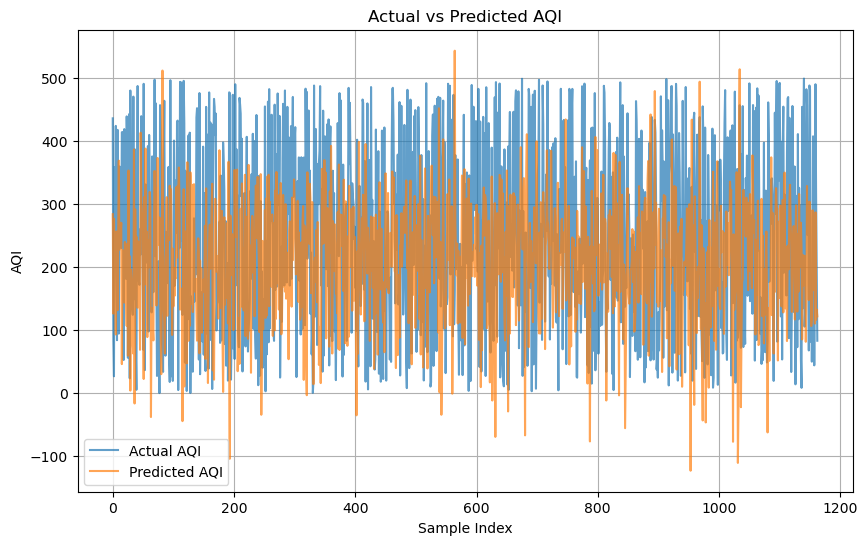

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual AQI", alpha=0.7)
plt.plot(y_pred_rescaled, label="Predicted AQI", alpha=0.7)
plt.title("Actual vs Predicted AQI")
plt.xlabel("Sample Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()


Epoch 100/500, Loss: 0.4612
Epoch 200/500, Loss: 0.4194
Epoch 300/500, Loss: 0.3842
Epoch 400/500, Loss: 0.4089
Epoch 500/500, Loss: 0.3876


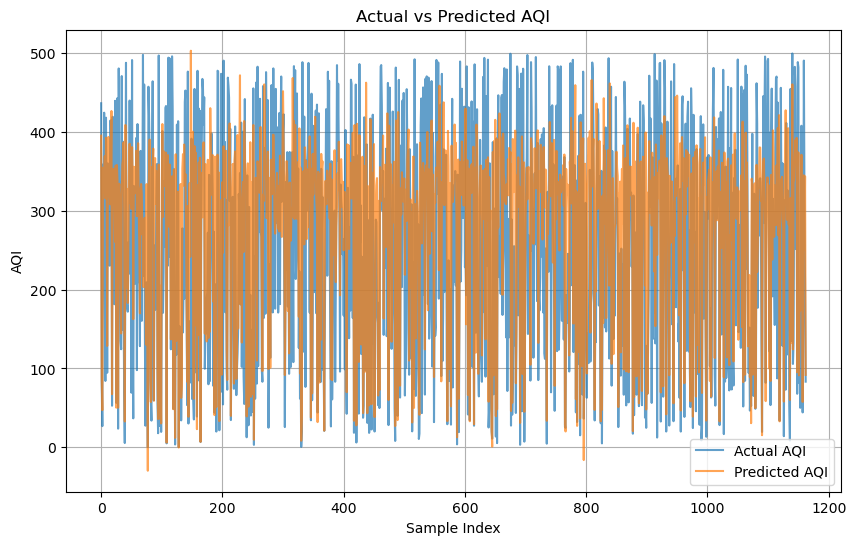

Test Loss: 13835.7347
Test Accuracy: 0.3435


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare the dataset
file_path = "datasets/finalProjectDataset.csv"  # Update the path if necessary
data = pd.read_csv(file_path)

# Select relevant features and target
relevant_columns = [
     "PM10", "PM2_5", "NO2", "SO2", "O3", "Temperature", "Humidity", "WindSpeed", "HealthImpactScore"
]
X = data[relevant_columns].values
y = data["AQI"].values

# Generate polynomial features manually (degree 2)
def generate_polynomial_features(X, degree):
    n_samples, n_features = X.shape
    poly_features = [X]

    for d in range(2, degree + 1):
        for i in range(n_features):
            for j in range(i, n_features):
                poly_features.append((X[:, i] * X[:, j]).reshape(-1, 1))

    return np.hstack(poly_features)

X_poly = generate_polynomial_features(X, 22)

# Normalize the features
X_mean, X_std = X_poly.mean(axis=0), X_poly.std(axis=0)
X_normalized = (X_poly - X_mean) / (X_std + 1e-8)  # Add small value to prevent division by zero

y_mean, y_std = y.mean(), y.std()
y_normalized = (y - y_mean) / (y_std + 1e-8)

# Split into training and testing sets (80% train, 20% test)
split_index = int(0.8 * len(X_normalized))
X_train, X_test = X_normalized[:split_index], X_normalized[split_index:]
y_train, y_test = y_normalized[:split_index], y_normalized[split_index:]

# Define the neural network class
class NeuralNetwork4:
    def __init__(self, input_size, hidden_sizes, output_size):
        # Initialize weights and biases for a multi-layer network
        self.layers = len(hidden_sizes) + 1
        self.weights = []
        self.biases = []

        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2 / layer_sizes[i]))
            self.biases.append(np.zeros((1, layer_sizes[i + 1])))

    def leaky_relu(self, Z, alpha=0.1):
        return np.where(Z > 0, Z, alpha * Z)

    def leaky_relu_derivative(self, Z, alpha=0.1):
        return np.where(Z > 0, 1, alpha)

    def forward_propagation(self, X):
        self.activations = [X]
        self.z_values = []

        for W, b in zip(self.weights[:-1], self.biases[:-1]):
            Z = np.dot(self.activations[-1], W) + b
            self.z_values.append(Z)
            self.activations.append(self.leaky_relu(Z))

        # Output layer (linear activation for regression)
        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.z_values.append(Z)
        self.activations.append(Z)

        return Z

    def compute_loss(self, Y, A):
        m = Y.shape[0]
        loss = np.mean((A - Y.reshape(-1, 1)) ** 2)  # Mean Squared Error
        return loss

    def backward_propagation(self, X, Y, output, lambda_reg):
        m = X.shape[0]
        dZ = (output - Y.reshape(-1, 1)) / m

        dWs = []
        dbs = []

        for i in reversed(range(self.layers)):
            dW = np.dot(self.activations[i].T, dZ) + (lambda_reg / m) * self.weights[i]
            db = np.sum(dZ, axis=0, keepdims=True)

            dWs.insert(0, dW)
            dbs.insert(0, db)

            if i > 0:
                dA = np.dot(dZ, self.weights[i].T)
                dZ = dA * self.leaky_relu_derivative(self.z_values[i - 1])

        # Update weights and biases
        for i in range(self.layers):
            self.weights[i] -= learning_rate * dWs[i]
            self.biases[i] -= learning_rate * dbs[i]

    def train(self, X_train, y_train, learning_rate, epochs, lambda_reg):
        for epoch in range(epochs):
            # Forward propagation
            output = self.forward_propagation(X_train)

            # Compute loss
            loss = self.compute_loss(y_train, output)

            # Backward propagation
            self.backward_propagation(X_train, y_train, output, lambda_reg)

            # Logging
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return self.forward_propagation(X)

# Hyperparameters
input_size = X_train.shape[1]  # Number of input features
hidden_sizes = [128, 64, 32, 16]  # More hidden layers with varying sizes
output_size = 1  # Single output for regression
learning_rate = 0.1
epochs = 500
lambda_reg = 0.01  # Regularization strength

# Initialize the network
nn = NeuralNetwork4(input_size, hidden_sizes, output_size)

# Train the model
nn.train(X_train, y_train, learning_rate, epochs, lambda_reg)

# Evaluate the model
y_pred = nn.predict(X_test).flatten()
y_pred_rescaled = y_pred * y_std + y_mean  # Rescale predictions to original scale
y_test_rescaled = y_test * y_std + y_mean  # Rescale test values to original scale

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual AQI", alpha=0.7)
plt.plot(y_pred_rescaled, label="Predicted AQI", alpha=0.7)
plt.title("Actual vs Predicted AQI")
plt.xlabel("Sample Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

# Compute Test Loss
test_loss = np.mean((y_pred_rescaled - y_test_rescaled) ** 2)
print(f"Test Loss: {test_loss:.4f}")

# Calculate accuracy as 1 - (normalized error)
accuracy = 1 - (test_loss / (np.var(y_test_rescaled) + 1e-8))  # Prevent division by zero
print(f"Test Accuracy: {accuracy:.4f}")
